In [1]:
import cleverhans
import torch

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method  
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
import os


In [3]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=10, shuffle=True)
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=10, shuffle=True)


### 超参数定义

In [4]:
# 超参数设置
batch_size = 32
epoch = 5
learning_rate = 0.005
# 生成对抗样本的个数
adver_nums = 1000

### Model def

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [6]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
device

In [8]:

# 初始化网络，并定义优化器
#simple_model = Net()
simple_model = Net().cuda()

In [ ]:
optimizer = torch.optim.SGD(simple_model.parameters(),lr = learning_rate,momentum=0.9)
print (simple_model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
def train(model,optimizer):
    model.train()
    for i in range(epoch):
        loss_tol=0
        for j,(data,target) in tqdm(enumerate(train_loader)):
            data=data.to(device)
            target=target.to(device)
            pred=model(data)
            loss=F.nll_loss(pred,target)
            loss_tol+=loss
            model.zero_grad()
            loss.backward()
            optimizer.step()
        print ('第{}个epoch，loss值等于{}'.format(i,loss_tol))
        

In [ ]:
simple_model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [ ]:
if os.path.exists("./model/model.pt"):
    simple_model.load_state_dict(torch.load("./model/model.pt"))
else:
    train(simple_model,optimizer)
    model_save_path = os.path.join("./model", 'model.pt')
    torch.save(simple_model.state_dict(), model_save_path)

In [ ]:
def test(model,name):
  correct_num = torch.tensor(0).to(device)
  for j,(data,target) in tqdm(enumerate(test_loader)):
    data = data.to(device)
    target = target.to(device)
    logit = model(data)
    pred = logit.max(1)[1]
    num = torch.sum(pred==target)
    correct_num = correct_num + num
  print (correct_num)
  print ('\n{} correct rate is {}'.format(name,correct_num/10000))
test(simple_model,"simple_model")

1000it [00:03, 257.30it/s]

tensor(9567, device='cuda:0')

simple_model correct rate is 0.9566999673843384


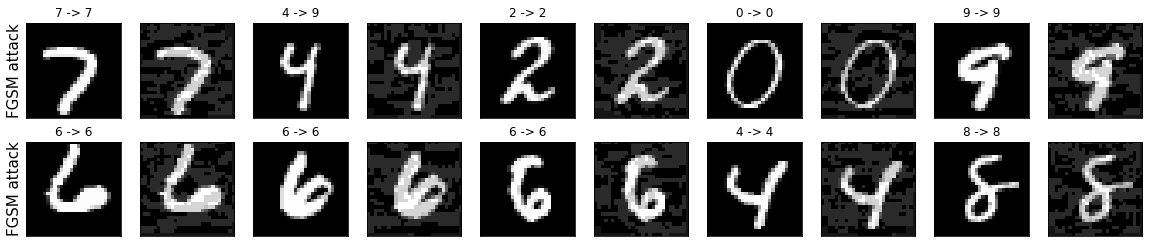

RuntimeError: The size of tensor a (32) must match the size of tensor b (10) at non-singleton dimension 0

In [ ]:


def plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name):
  n_cols = 2
  n_rows = 5
  cnt = 1
  cnt1 = 1
  plt.figure(figsize=(4*n_rows,2*n_cols))
  for i in range(n_cols):
    for j in range(n_rows):
      plt.subplot(n_cols,n_rows*2,cnt1)
      plt.xticks([])
      plt.yticks([])
      if j == 0:
        plt.ylabel(attack_name,size=15)
      plt.title("{} -> {}".format(clean_target[cnt-1], adver_target[cnt-1]))
      plt.imshow(clean_example[cnt-1].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      plt.subplot(n_cols,n_rows*2,cnt1+1)
      plt.xticks([])
      plt.yticks([])
      # plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(adver_example[cnt-1].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      cnt = cnt + 1
      cnt1 = cnt1 + 2
  plt.show()
  print ('\n')


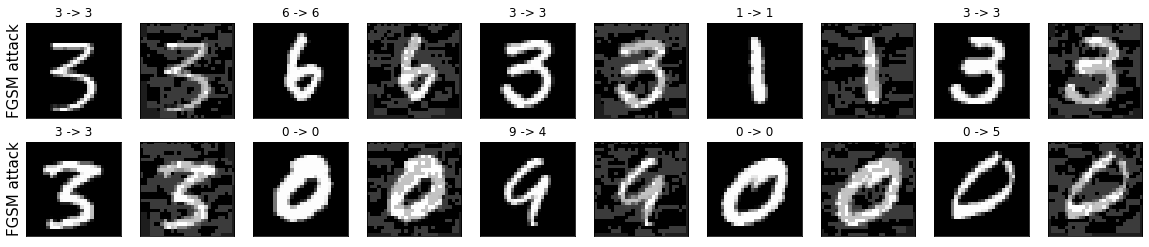

In [ ]:
def FGSM(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  for i,(data,target) in enumerate(test_loader):
    if i>=1:
      break
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = fast_gradient_method(model, data.to(device), 0.15, np.inf)
    adver_target = torch.max(model(adver_example),1)[1]
    clean_example = data
    clean_target = target
  return adver_example,adver_target,clean_example,clean_target,'FGSM attack'

adver_example,adver_target,clean_example,clean_target,attack_name= FGSM(simple_model)
plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name)

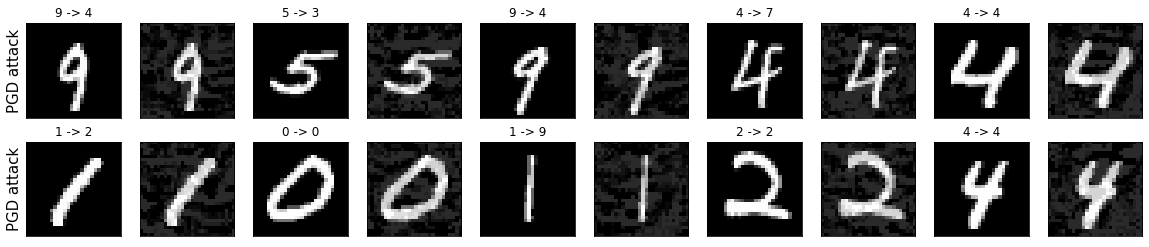

In [ ]:
def PGD(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  for i,(data,target) in enumerate(test_loader):
    if i>=1:
      break
    # model_fn = lambda x:F.nll_loss(model(x),target.to(device))
    adver_example = projected_gradient_descent(model, data.to(device),0.1,0.05,40,np.inf)
    adver_target = torch.max(model(adver_example),1)[1]
    clean_example = data
    clean_target = target
  return adver_example,adver_target,clean_example,clean_target,'PGD attack'
adver_example,adver_target,clean_example,clean_target,attack_name= PGD(simple_model)
plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name)

In [ ]:
def CW(model):
  adver_example = None
  adver_target = None
  clean_example = None
  clean_target = None
  for i,(data,target) in enumerate(test_loader):
    if i>=1:
      break
    adver_example = carlini_wagner_l2(model, data.to(device), 10, y = torch.tensor([3]*batch_size,device = device) ,targeted = True)
    adver_target = torch.max(model(adver_example),1)[1]
    clean_example = data
    clean_target = target
  return adver_example,adver_target,clean_example,clean_target,'CW attack'

adver_example,adver_target,clean_example,clean_target,attack_name= carlini_wagner_l2(simple_model)
plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name)

TypeError: carlini_wagner_l2() missing 2 required positional arguments: 'x' and 'n_classes'

In [ ]:
def plot_clean_and_adver(adver_example,adver_target,clean_example,clean_target,attack_name):
  n_cols = 2
  n_rows = 5
  cnt = 1
  cnt1 = 1
  plt.figure(figsize=(4*n_rows,2*n_cols))
  for i in range(n_cols):
    for j in range(n_rows):
      plt.subplot(n_cols,n_rows*2,cnt1)#(2,10,1)
      plt.xticks([])
      plt.yticks([])
      if j == 0:
        plt.ylabel(attack_name,size=15)
      plt.title("{} -> {}".format(clean_target[cnt-1], adver_target[cnt-1]))
      plt.imshow(clean_example[cnt-1].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      plt.subplot(n_cols,n_rows*2,cnt1+1)
      plt.xticks([])
      plt.yticks([])
      # plt.title("{} -> {}".format(clean_target[cnt], adver_target[cnt]))
      plt.imshow(adver_example[cnt-1].reshape(28,28).to('cpu').detach().numpy(),cmap='gray')
      cnt = cnt + 1
      cnt1 = cnt1 + 2
  plt.show()
  print ('\n')

In [ ]:
import numpy as np
def DFT(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]      # the number of samples
    n = np.arange(N)    
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

test_data =[1,2,1,1]
print(DFT(test_data))
print(np.fft.fft(test_data))

[ 5.00000000e+00+0.0000000e+00j  3.83475851e-17-1.0000000e+00j
 -1.00000000e+00-3.6739404e-16j  2.18024152e-16+1.0000000e+00j]
[ 5.+0.j  0.-1.j -1.+0.j  0.+1.j]
